In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb

In [2]:
# Step 1: Load the dataset
data = pd.read_csv('crypto_yearly_data.csv')

# Drop unnecessary columns
data = data.drop('year', axis=1)

In [3]:
data.shape

(932922, 5)

In [4]:
# Create lag features (e.g., past 100 days' close prices as features)
def create_lag_features(data, target_column, n_lags):
    for lag in range(1, n_lags + 1):
        data[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)
    data = data.dropna()  # Remove rows with NaN values created by the lag features
    return data


In [5]:
# Create lag features for the "close" column
n_lags = 100
data = create_lag_features(data, 'close', n_lags)


C:\Users\Muhammad Aqeel\AppData\Local\Temp\ipykernel_13232\2092996551.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)


In [6]:
# Step 2: Prepare the data for training
# Extract features and target
features = data.drop('close', axis=1).values
labels = data['close'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Convert data to DMatrix format (required for xgb.train())
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for XGBoost
params = {
    "objective": "reg:squarederror",  # Regression objective
    "learning_rate": 0.01,  # Learning rate,  
    "max_depth": 6, # Depth of each tree
    "subsample": 0.8, # Subsample ratio of the training data
    "colsample_bytree": 0.8,# Subsample ratio of columns
    "seed": 42,
}

# Train the model with early stopping
print("Training the XGBoost model...")
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    evals=[(dtest, "eval")],  # Evaluation set
    early_stopping_rounds=50,  # Stops if no improvement
    verbose_eval=True,  # Show training progress
)



Training the XGBoost model...
[0]	eval-rmse:13736.17442
[1]	eval-rmse:13598.87988
[2]	eval-rmse:13462.97747
[3]	eval-rmse:13328.44006
[4]	eval-rmse:13195.24308
[5]	eval-rmse:13063.36296
[6]	eval-rmse:12932.80864
[7]	eval-rmse:12803.56161
[8]	eval-rmse:12675.60663
[9]	eval-rmse:12548.93917
[10]	eval-rmse:12423.52464
[11]	eval-rmse:12299.36712
[12]	eval-rmse:12176.44568
[13]	eval-rmse:12054.76677
[14]	eval-rmse:11934.30062
[15]	eval-rmse:11815.03597
[16]	eval-rmse:11696.97021
[17]	eval-rmse:11580.08062
[18]	eval-rmse:11464.35052
[19]	eval-rmse:11349.78806
[20]	eval-rmse:11236.36852
[21]	eval-rmse:11124.08946
[22]	eval-rmse:11012.93274
[23]	eval-rmse:10902.88006
[24]	eval-rmse:10793.93715
[25]	eval-rmse:10686.07450
[26]	eval-rmse:10579.29126
[27]	eval-rmse:10473.59234
[28]	eval-rmse:10368.92195
[29]	eval-rmse:10265.31541
[30]	eval-rmse:10162.74503
[31]	eval-rmse:10061.19552
[32]	eval-rmse:9960.65079
[33]	eval-rmse:9861.12358
[34]	eval-rmse:9762.60466
[35]	eval-rmse:9665.05436
[36]	eval-rm

In [8]:
# Make predictions
y_pred = xgb_model.predict(dtest)

# Evaluate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Model Performance:
Mean Absolute Error (MAE): 31.957969225223994
Mean Squared Error (MSE): 27212.355186498986
Root Mean Squared Error (RMSE): 164.96167793308538
R² Score: 0.9998586454032531


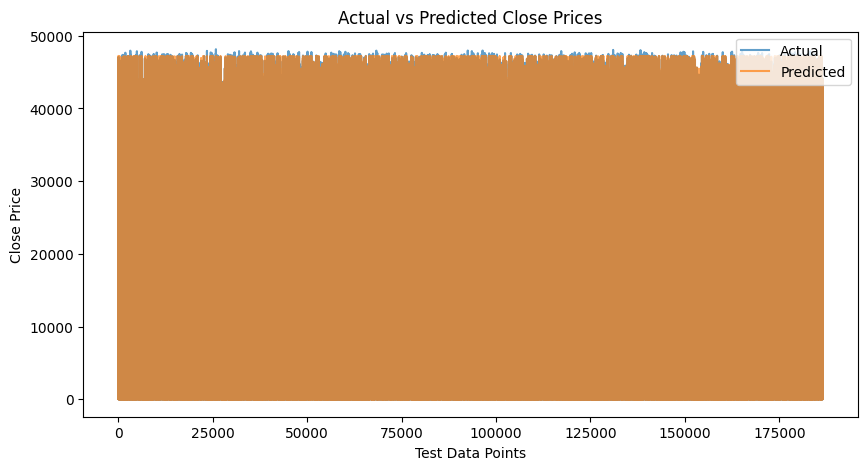

In [9]:
# Step 5: Visualize predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Test Data Points")
plt.ylabel("Close Price")
plt.show()

In [10]:
# Step 6: Save the model
xgb_model.save_model("xgboost_crypto_train_model.json")
print("XGBoost model saved to 'xgboost_crypto_model.json'.")


XGBoost model saved to 'xgboost_crypto_model.json'.
